<a href="https://colab.research.google.com/github/KimTaesuk11/KimTaesuk11/blob/main/Section2_AI_08_%EA%B9%80%ED%83%9C%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
# Airbnb 2020년 미국 데이터셋.(출처 : kagle)
from google.colab import files
myfile = files.upload()

Saving AB_US_2020.csv to AB_US_2020 (1).csv


In [9]:
import io
import pandas as pd

df = pd.read_csv(io.BytesIO(myfile['AB_US_2020.csv']))
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [11]:
Missingvalues = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("Missing Values(%) : " + str(round(Missingvalues,5)) + " %")

Missing Values(%) : 5.54611 %


In [12]:
df=df.drop(['id','name','host_id','host_name','neighbourhood_group',
                'last_review', "reviews_per_month"], axis=1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226030 entries, 0 to 226029
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   neighbourhood                   226030 non-null  object 
 1   latitude                        226030 non-null  float64
 2   longitude                       226030 non-null  float64
 3   room_type                       226030 non-null  object 
 4   price                           226030 non-null  int64  
 5   minimum_nights                  226030 non-null  int64  
 6   number_of_reviews               226030 non-null  int64  
 7   calculated_host_listings_count  226030 non-null  int64  
 8   availability_365                226030 non-null  int64  
 9   city                            226030 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 17.2+ MB


In [14]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
count,226030.000000,226030.000000,226030.000000,2.260300e+05,226030.000000,226030.000000,226030.000000
mean,35.662829,-103.220662,219.716529,4.525490e+02,34.506530,16.698562,159.314856
std,6.849855,26.222091,570.353609,2.103376e+05,63.602914,51.068966,140.179628
min,18.920990,-159.714900,0.000000,1.000000e+00,0.000000,1.000000,0.000000
25%,32.761783,-118.598115,75.000000,1.000000e+00,1.000000,1.000000,0.000000
50%,37.261125,-97.817200,121.000000,2.000000e+00,8.000000,2.000000,140.000000
75%,40.724038,-76.919322,201.000000,7.000000e+00,39.000000,6.000000,311.000000
max,47.734620,-70.995950,24999.000000,1.000000e+08,966.000000,593.000000,365.000000


In [16]:
df['price'].quantile(.95)

599.0

In [17]:
lower_bound = .0
upper_bound = .95
df = df[df['price'].between(df['price'].quantile(lower_bound), 
            df['price'].quantile(upper_bound), inclusive=True)].reset_index(drop=True)

In [18]:
airbnb = df.copy()
airbnb = airbnb[airbnb['calculated_host_listings_count'] < 10]
#숙소 호스트가 운영 중인 숙소의 개수
airbnb = airbnb[airbnb['number_of_reviews'] > 30]
#리뷰의 수
airbnb = airbnb[airbnb['minimum_nights'] < 10]
#최소 숙박

In [19]:
airbnb['price'].quantile(.95)

320.0

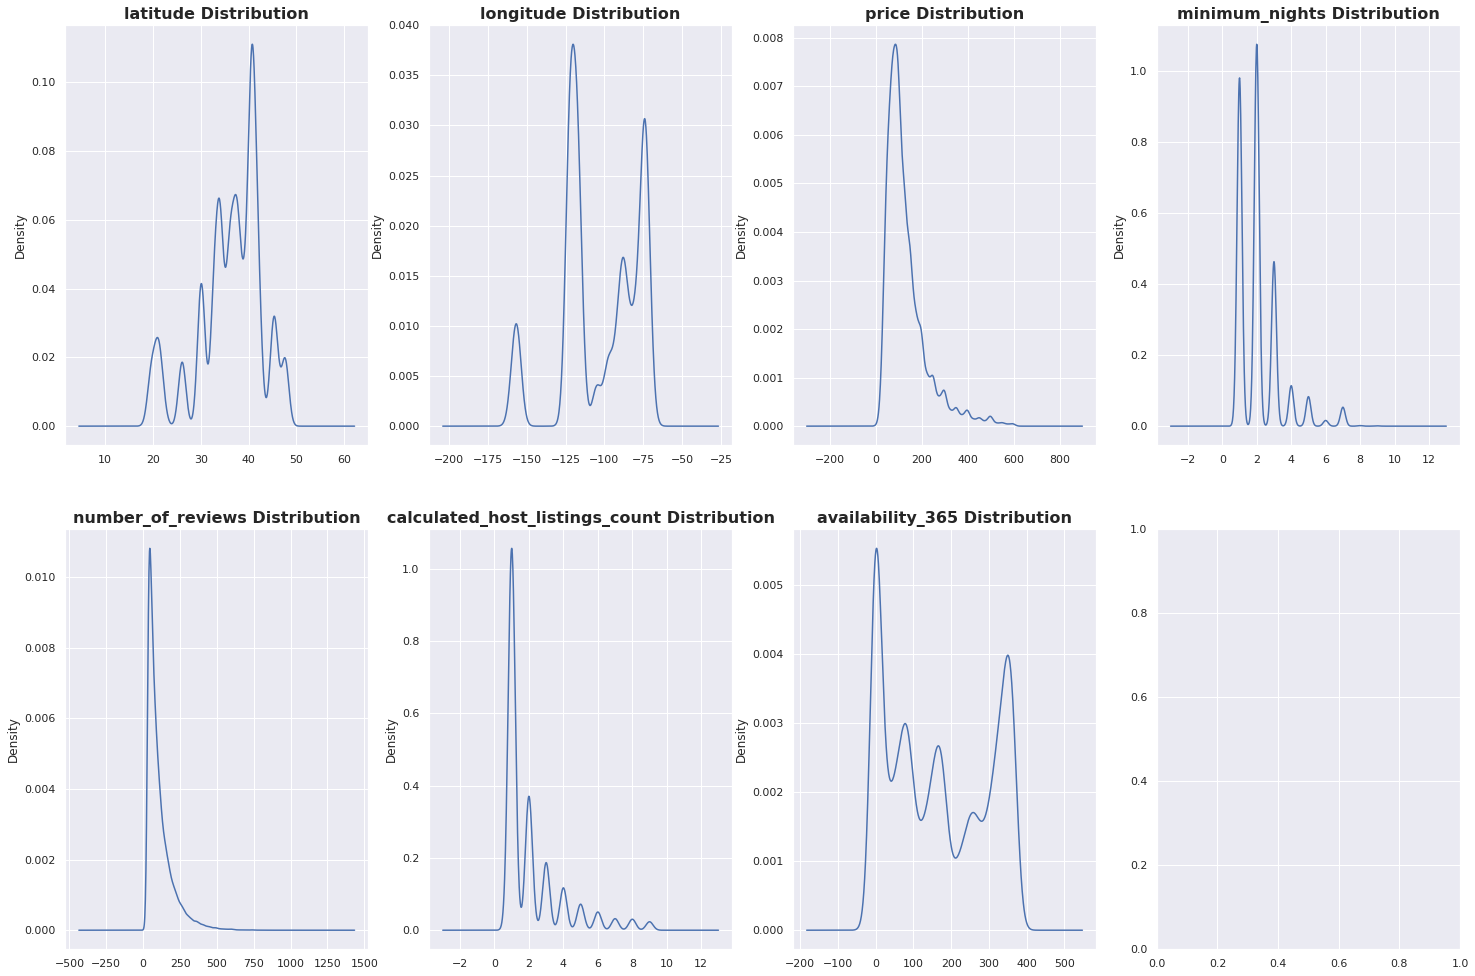

In [20]:
numeric_ix =df.select_dtypes(include=['int64', 'float64']).columns

fig, axes = plt.subplots(nrows=2, ncols=4)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        airbnb[numeric_ix[aux]].plot(kind='kde',ax=col)
        col.set_title(numeric_ix[aux] +' Distribution',fontsize=16,fontweight='bold')
        aux+=1
        if aux==len(numeric_ix):
            break

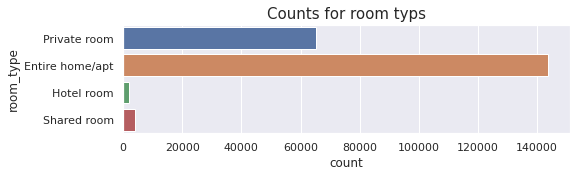

In [21]:
plt.figure(figsize=(8,2))
sns.countplot(y="room_type", data=df)
plt.title("Counts for room typs", size=15)
plt.show()

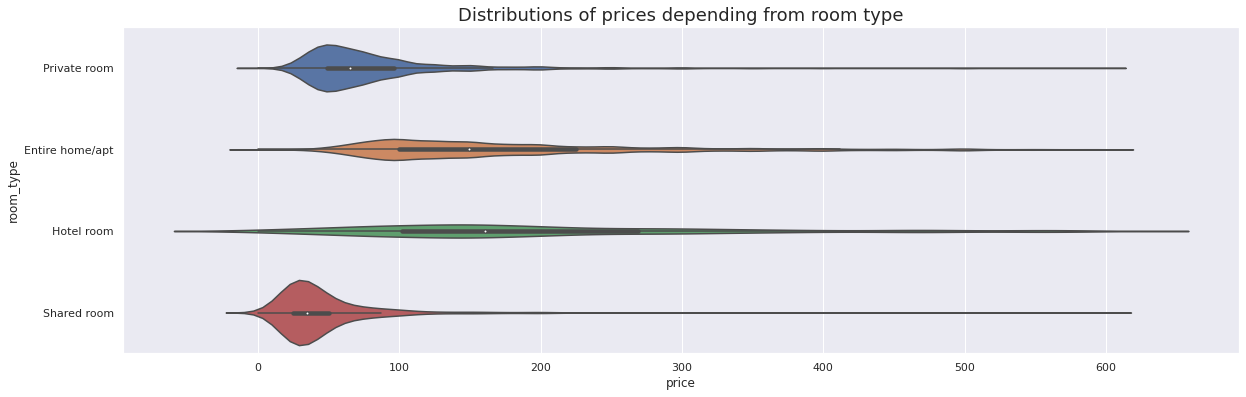

In [23]:
plt.figure(figsize=(20,6))
sns.violinplot(x="price", y="room_type", showfliers = False, data=df)
plt.title("Distributions of prices depending from room type", size=18)
plt.show()

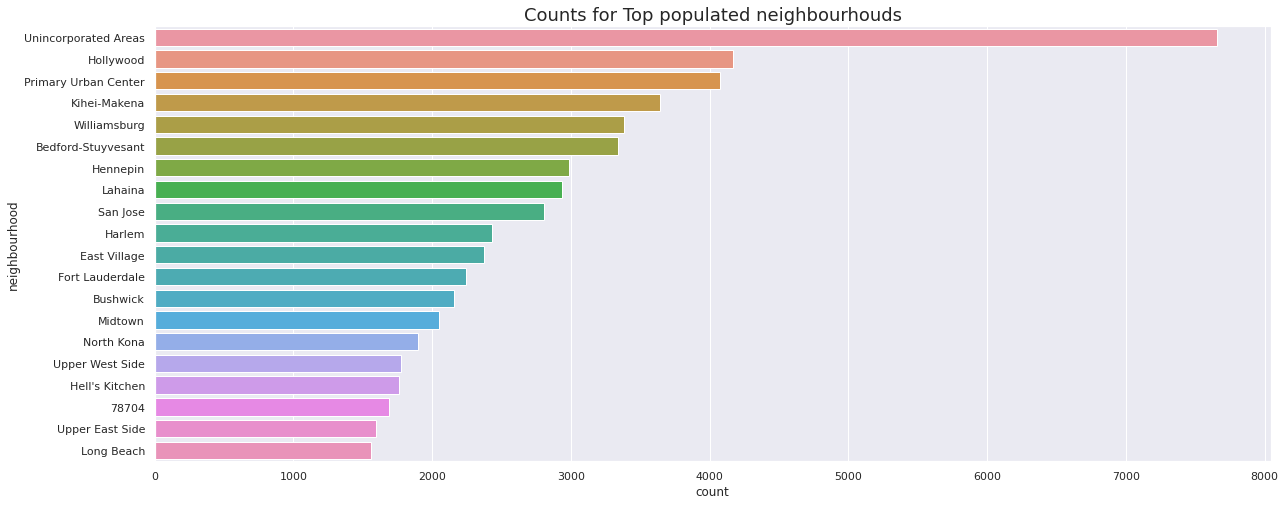

In [24]:
plt.figure(figsize=(20,8))
sns.countplot(y="neighbourhood", data=df, order=df.neighbourhood.value_counts().iloc[:20].index)
plt.title("Counts for Top populated neighbourhouds", size=18)
plt.show()

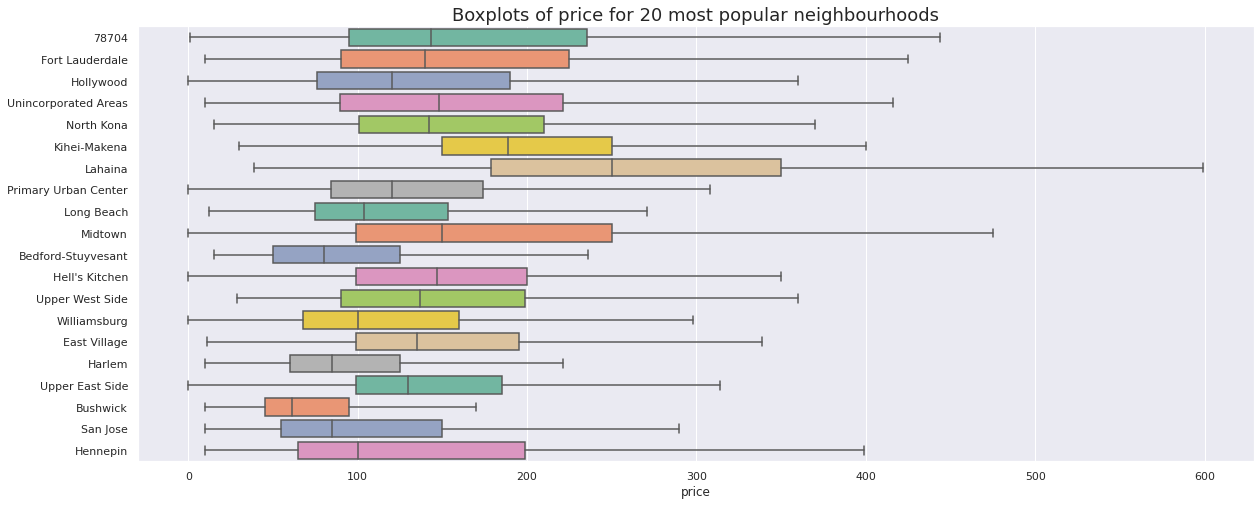

In [26]:
top20 = list(df.neighbourhood.value_counts().iloc[:20].index)

plt.figure(figsize=(20,8))
sns.boxplot(x="price", y="neighbourhood", data=df.loc[df['neighbourhood'].isin(top20)], \
            showfliers = False, palette="Set2")
plt.title("Boxplots of price for 20 most popular neighbourhoods", size=18)
plt.ylabel('')
plt.show()

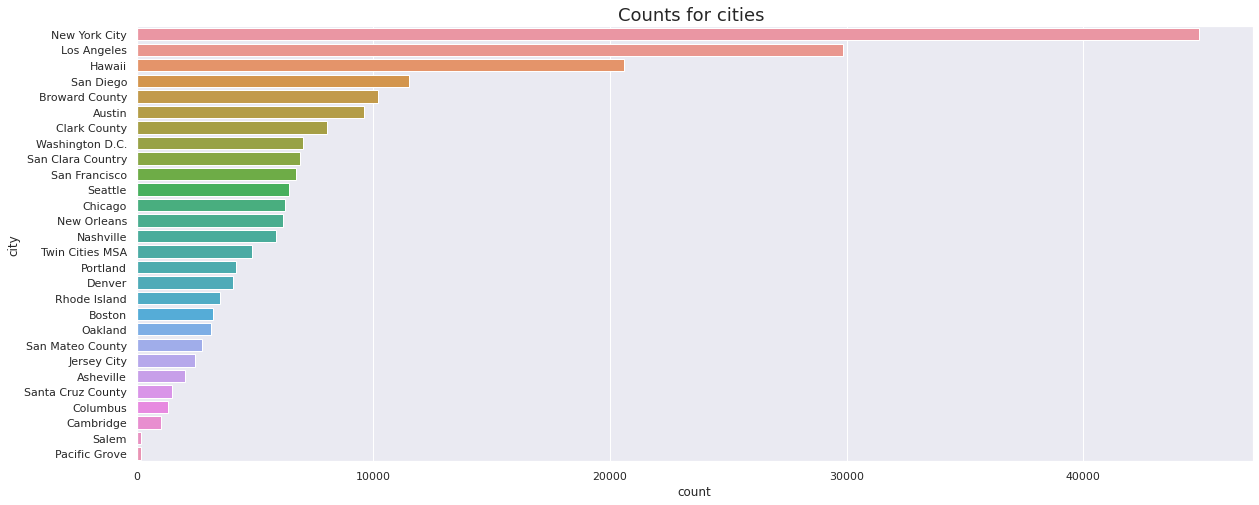

In [27]:
plt.figure(figsize=(20,8))
sns.countplot(y="city", data=df, order=df.city.value_counts().index)
plt.title("Counts for cities ", size=18)
plt.show()

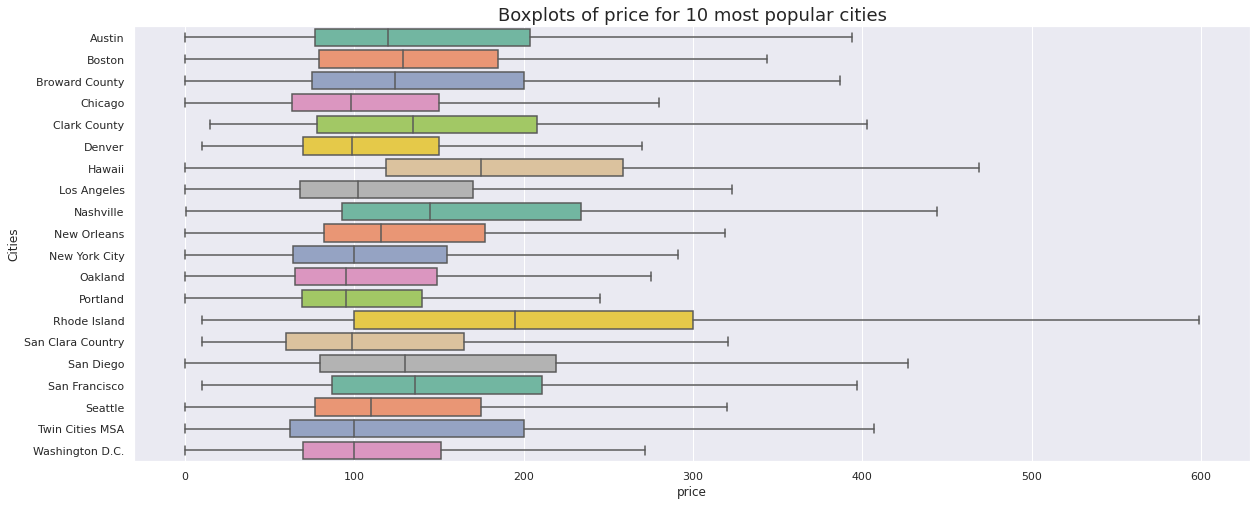

In [28]:
top_city = list(df.city.value_counts().iloc[:20].index)

plt.figure(figsize=(20,8))
sns.boxplot(x="price", y="city", data=df.loc[df['city'].isin(top_city)], 
            showfliers = False, palette="Set2")
plt.title('Boxplots of price for 10 most popular cities', size=18)
plt.ylabel('Cities')
plt.show()

In [29]:
# Feature Engineering
numeric_ix=airbnb.select_dtypes(include=['int64', 'float64']).columns.drop('price')

to_categorical_list = ['neighbourhood','room_type','city']
for i in to_categorical_list:
    airbnb[i]=airbnb[i].astype('category')
    
labelencoder = LabelEncoder()
for i in to_categorical_list:
    airbnb[i] = labelencoder.fit_transform(airbnb[i])
airbnb.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,city
0,5,35.65146,-82.62792,2,60,1,138,1,0,0
3,7,35.57864,-82.59578,0,90,1,267,5,0,0
5,5,35.61856,-82.55276,0,134,7,54,1,294,0
6,7,35.58345,-82.59713,2,48,1,137,1,0,0
7,6,35.59635,-82.50655,2,65,3,57,2,106,0


In [30]:
train_set, test_set = train_test_split(airbnb, test_size=0.2, random_state=2)

In [31]:
x_train=train_set.drop(['price'], axis=1)
y_train=train_set['price']

x_test=test_set.drop(['price'], axis=1)
y_test=test_set['price']

In [32]:
#XGBRegressor 사용을 위한 별도 Sample
train_sample=train_set.sample(frac=0.4, replace=True, random_state=2)

In [33]:
x_train_sample=train_sample.drop(['price'], axis=1)
y_train_sample=train_sample['price']

In [34]:
#One Hot Encoding
t = [('cat', OneHotEncoder(), ['room_type','city'])]
col_transform = ColumnTransformer(transformers=t,remainder='passthrough')

x_train = pd.DataFrame(col_transform.fit_transform(x_train).toarray())
x_test = pd.DataFrame(col_transform.fit_transform(x_test).toarray())

x_train_sample = pd.DataFrame(col_transform.fit_transform(x_train_sample).toarray())

In [35]:
# 순서형 데이터 일반화

mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_test -= mean
x_test /= std

x_train_sample -= mean
x_train_sample /= std

In [36]:
import xgboost as xgb

booster = xgb.XGBRegressor()

In [37]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 200, 300],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [5, 7, 10],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(x_train_sample, y_train_sample)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

[07:27:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}


In [38]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=10, n_estimators=300, random_state=4)

# train
booster.fit(x_train, y_train)

# predict
y_pred_train = booster.predict(x_train)
y_pred_test = booster.predict(x_test)

[07:27:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [41]:
print(np.sqrt(mean_squared_error(y_train, y_pred_train)))
print(np.sqrt(mean_squared_error(y_test, y_pred_test)))

42.072609999264394
72.77699164760384


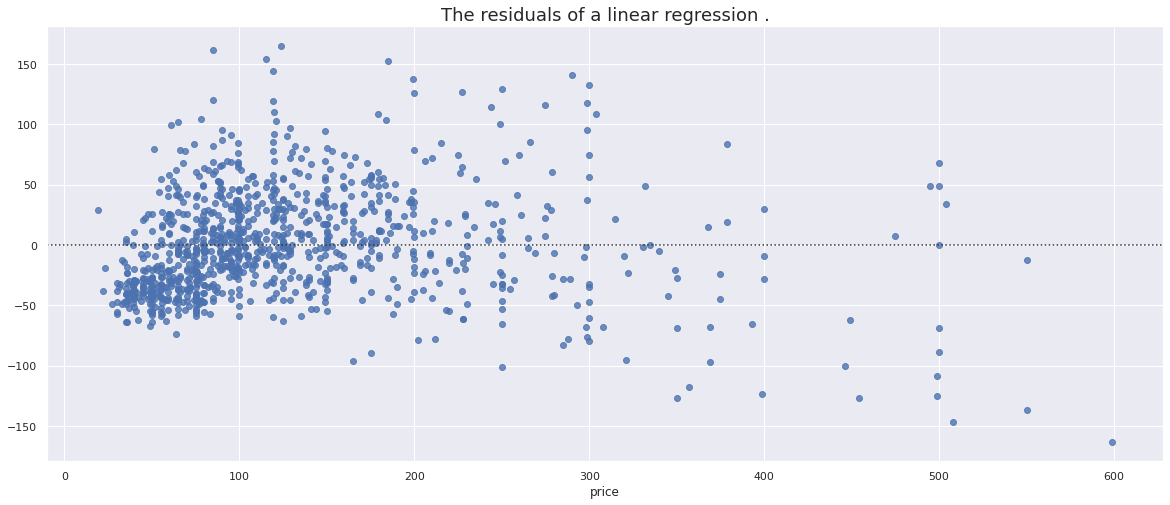

In [42]:
plt.figure(figsize=(20,8))
sns.residplot(x=y_test[:1000],y=y_pred_test[:1000])
plt.title('The residuals of a linear regression .', size=18)
plt.show()